In [ ]:
!pip install scikit-fuzzy

In [193]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import skfuzzy as fuzz
import skfuzzy.control as ctrl

In [194]:
# !pip install streamlit

In [195]:
import numpy as np
import sklearn
import imblearn
import pandas as pd
import xgboost
import matplotlib
import skfuzzy

print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Scikit-learn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)
print("xgboost:", xgboost.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-fuzzy:", skfuzzy.__version__)

Pandas: 2.2.2
NumPy: 2.0.2
Scikit-learn: 1.6.1
imblearn: 0.13.0
xgboost: 2.1.4
matplotlib: 3.10.0
scikit-fuzzy: 0.5.0


In [196]:
# Load dataset
df = pd.read_csv('/content/diabetes.csv')
print(df.head())
# Handle categorical features
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
df[categorical_cols] = df[categorical_cols].astype(str)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [197]:
# Features and target
x = df.drop(columns=['diabetes'], axis=1)
y = df['diabetes']
with open('features.pkl','wb') as file:
  pickle.dump(x.columns,file)

#implementing a fuzzy system for handling uncertainty

In [198]:
# Define fuzzy variables
hba1c = ctrl.Antecedent(np.arange(3, 15, 0.1), 'HbA1c_level')
bmi = ctrl.Antecedent(np.arange(10, 50, 0.1), 'bmi')
glucose = ctrl.Antecedent(np.arange(50, 300, 1), 'blood_glucose_level')
risk = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'diabetes_risk')
hypertension_range = np.arange(0, 1.1, 0.1)
hypertension_fuzzy = ctrl.Antecedent(hypertension_range, 'hypertension')
smoking_range = np.arange(0, 1.1, 0.1)
smoking_fuzzy = ctrl.Antecedent(smoking_range, 'smoking')

In [199]:
#Define fuzzy sets (Low, Medium, High)
hba1c.automf(3)
bmi.automf(3)
glucose.automf(3)
risk.automf(3)
#Defining fuzzy set for categorical data
hypertension_fuzzy['absent'] = fuzz.trimf(hypertension_fuzzy.universe, [0, 0, 0.5])
hypertension_fuzzy['present'] = fuzz.trimf(hypertension_fuzzy.universe, [0.5, 1, 1])
smoking_fuzzy['never'] = fuzz.trimf(smoking_fuzzy.universe, [0, 0, 0.3])
smoking_fuzzy['former'] = fuzz.trimf(smoking_fuzzy.universe, [0.2, 0.5, 0.8])
smoking_fuzzy['current'] = fuzz.trimf(smoking_fuzzy.universe, [0.7, 1, 1])

In [201]:
# Example fuzzy rules that incorporate all factors:
rule1 = ctrl.Rule(hba1c['good'] & bmi['good'] & hypertension_fuzzy['present'] & smoking_fuzzy['current'], risk['good'])
rule2 = ctrl.Rule(hba1c['average'] & glucose['average'] & hypertension_fuzzy['absent'] & smoking_fuzzy['former'], risk['average'])
rule3 = ctrl.Rule(hba1c['poor'] & glucose['poor'] & hypertension_fuzzy['absent'] & smoking_fuzzy['never'], risk['poor'])

# Create fuzzy control system
risk_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)
#saving the fuzzy model
with open("fuzzy.pkl", "wb+") as file:
    pickle.dump(risk_ctrl, file)


In [202]:
print(x.shape,y.shape)

(100000, 13) (100000,)


In [203]:
#finding missing values
df.isnull().sum()

,0
age,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0
gender_Male,0
gender_Other,0
hypertension_1,0
heart_disease_1,0
smoking_history_current,0


In [204]:
df.value_counts(['diabetes'])

,count
diabetes,
0,91500
1,8500


#our dataset is highly imbalanced so we correct it first

In [205]:
# Apply SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

In [206]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=43)

In [207]:
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
 diabetes
0    91500
1    91500
Name: count, dtype: int64


In [208]:
print(x_resampled.shape,y_resampled.shape)

(183000, 13) (183000,)


In [221]:
continuous_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_cols = [col for col in x_resampled.columns if col not in continuous_cols]

#standardizing and normalizing data

In [222]:
# #Standardizing only continuous features
# scaler = StandardScaler()
# x_train_continuous = pd.DataFrame(
#     scaler.fit_transform(x_train[continuous_cols]),
#     columns=continuous_cols,
#     index=x_train.index
# )
# x_train_scaled = pd.concat([x_train_continuous, x_train[categorical_cols]], axis=1)

# x_test_continuous = pd.DataFrame(
#     scaler.transform(x_test[continuous_cols]),
#     columns=continuous_cols,
#     index=x_test.index
# )
# x_test_scaled = pd.concat([x_test_continuous, x_test[categorical_cols]], axis=1)
# # Save the scaler
# with open("scaler.pkl", "wb+") as file:
#     pickle.dump(scaler, file)

#splitting the dataset in test and train data

In [223]:
hba1c_min = x_resampled['HbA1c_level'].min()
hba1c_max = x_resampled['HbA1c_level'].max()
x_train['HbA1c_level'] = (x_train['HbA1c_level'] - hba1c_min) / (hba1c_max - hba1c_min)
x_test['HbA1c_level'] = (x_test['HbA1c_level'] - hba1c_min) / (hba1c_max - hba1c_min)
with open('hba1c_min_max.pkl','wb+') as file:
  pickle.dump((hba1c_min,hba1c_max),file)

#Using gradient boosting


In [225]:
# Train XGBoost model
xgb_classifier = XGBClassifier(n_estimators=600, max_depth=7, learning_rate=0.05,
                               subsample=0.8, colsample_bytree=0.7,
                               gamma=1.15,random_state=9)
xgb_classifier.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.15, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, random_state=9, ...)

In [226]:
# Evaluating XGBoost accuracy
y_train_pred_xgb = xgb_classifier.predict(x_train)
y_test_pred_xgb = xgb_classifier.predict(x_test)

train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"XGBoost Training Accuracy: {100*train_acc_xgb:.5f} %")
print(f"XGBoost Testing Accuracy: {100*test_acc_xgb:.5f} %")

XGBoost Training Accuracy: 98.04098 %
XGBoost Testing Accuracy: 97.61202 %


In [227]:
with open("xgb_model.pkl", "wb+") as file:
    pickle.dump(xgb_classifier, file)

In [228]:
importances = xgb_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                        Feature  Importance
2                   HbA1c_level    0.302058
3           blood_glucose_level    0.209780
6                hypertension_1    0.137084
7               heart_disease_1    0.063586
4                   gender_Male    0.056272
0                           age    0.047484
11        smoking_history_never    0.045482
10       smoking_history_former    0.045136
12  smoking_history_not current    0.028749
8       smoking_history_current    0.028373
9          smoking_history_ever    0.022197
1                           bmi    0.013799
5                  gender_Other    0.000000


#ROC analysis to find better threshold

In [235]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get probabilities
y_probs = xgb_classifier.predict_proba(x_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Find threshold for sensitivity >= 0.99
optimal_idx = np.argmax(tpr >= 0.99)  # First threshold where sensitivity >= 0.99
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold for Sensitivity >= 0.99: {optimal_threshold:.3f}")
print(f"Sensitivity at this threshold: {tpr[optimal_idx]:.3f}")
print(f"Specificity at this threshold: {1 - fpr[optimal_idx]:.3f}")

# Evaluate at the new threshold
y_pred_adjusted = (y_probs > optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_adjusted)
print("Confusion Matrix (New Threshold):\n", cm)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

ROC AUC: 0.9976273000089583
Threshold for Sensitivity >= 0.99: 0.160
Sensitivity at this threshold: 0.990
Specificity at this threshold: 0.922
Confusion Matrix (New Threshold):
 [[16877  1423]
 [  184 18116]]
Sensitivity: 0.990
Specificity: 0.922


In [231]:
# Adjusting decision threshold
y_probs = xgb_classifier.predict_proba(x_test)[:, 1]

# Set your decision threshold here (default is 0.5, change as needed)
threshold = 0.146

# Generate predictions based on the new threshold
y_pred_adjusted = (y_probs > threshold).astype(int)

# Evaluate the model using the adjusted predictions
from sklearn.metrics import confusion_matrix, accuracy_score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
print("Adjusted Accuracy:", accuracy_score(y_test, y_pred_adjusted))


Confusion Matrix:
 [[16741  1559]
 [  165 18135]]
Adjusted Accuracy: 0.952896174863388


CHECKING HOW OUR MODEL IS DEPENDENT ON FEATURES THROUGH A VISUAL REPRESENTATION

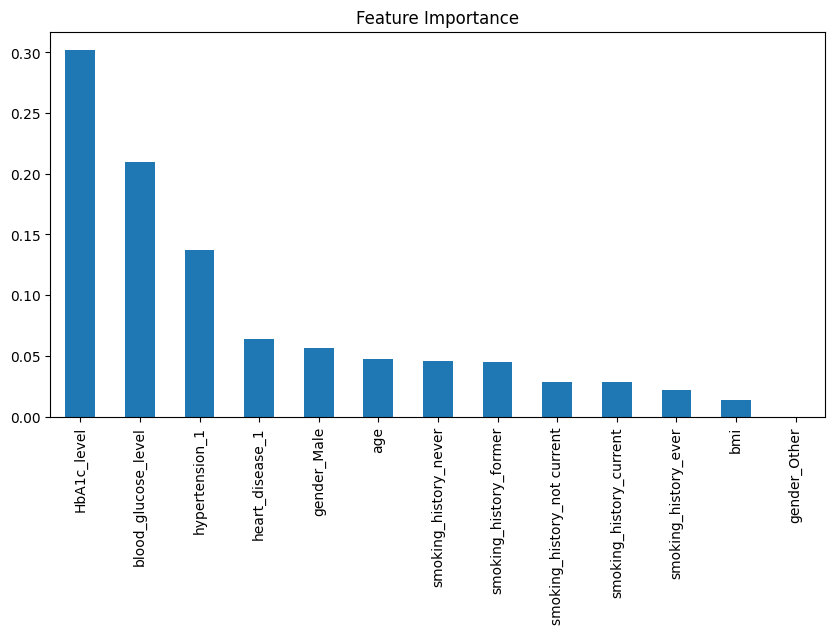

In [234]:
# Check feature importance in XGBoost
feature_importance = pd.Series(xgb_classifier.feature_importances_, index=x.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title="Feature Importance")
plt.show()


CHECKING OUR MODEL

In [174]:
!pip install shap
#print shap version
import shap
shap.__version__

'0.46.0'

In [233]:
print()